# Module 05: Logistic Regression

## Prerequisites

In [16]:
# Helper packages
import pandas as pd
from plotnine import *

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [17]:
churn = pd.read_csv("../../00-data/ML/attrition.csv")

# recode response variable to 1/0
churn = churn.replace({"Attrition": {"Yes": 1, "No": 0}})

# create train/test split
train, test = train_test_split(
  churn, 
  train_size=0.7, 
  random_state=123, 
  stratify=churn[["Attrition"]],
  )

# separate features from labels and only use numeric features
X_train = train.drop("Attrition", axis=1)
y_train = train[["Attrition"]].values.ravel()

## Simple logistic regression

In [18]:
# model 1
lr_mod = LogisticRegression()
lr_fit1 = lr_mod.fit(X_train[["MonthlyIncome"]], y_train)

In [19]:
overtime = pd.get_dummies(X_train[["OverTime"]].copy())

# model 2
lr_mod = LogisticRegression()
lr_fit2 = lr_mod.fit(overtime, y_train)

### Interpretation

In [20]:
lr_fit1.predict_proba(X_train[["MonthlyIncome"]])

array([[0.97549407, 0.02450593],
       [0.77634553, 0.22365447],
       [0.88111738, 0.11888262],
       ...,
       [0.77650326, 0.22349674],
       [0.83663367, 0.16336633],
       [0.79616027, 0.20383973]])

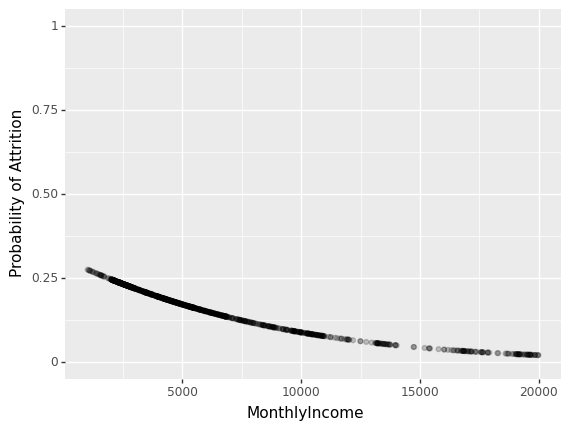

<ggplot: (17592024796977)>

In [21]:
pred = pd.DataFrame(
  lr_fit1.predict_proba(X_train[["MonthlyIncome"]]), 
  columns=["No", "Yes"]
  )
  
pred["MonthlyIncome"] = X_train["MonthlyIncome"].reset_index(drop=True)

(ggplot(pred, aes('MonthlyIncome', 'Yes'))
  + geom_point(alpha=0.2)
  + scale_y_continuous(name="Probability of Attrition", limits=(0, 1)))

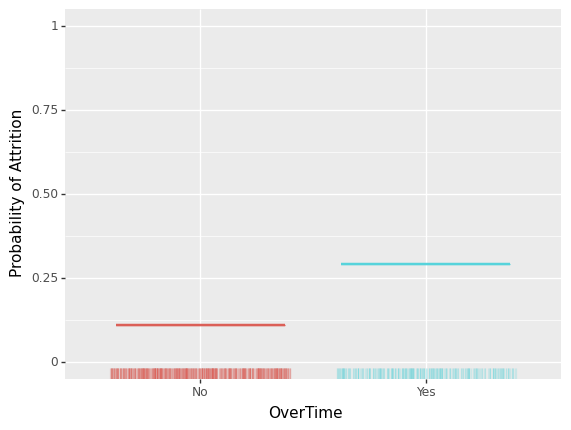

<ggplot: (17592024673015)>

In [22]:
pred = pd.DataFrame(
  lr_fit2.predict_proba(overtime),
  columns=["No", "Yes"]
  )

pred["OverTime"] = X_train["OverTime"].reset_index(drop=True)

(ggplot(pred, aes('OverTime', 'Yes', color='OverTime'))
  + geom_boxplot(show_legend=False)
  + geom_rug(sides="b", position="jitter", alpha=0.2, show_legend=False)
  + scale_y_continuous(name="Probability of Attrition", limits=(0, 1))
  )

## Multiple logistic regression

In [23]:
feat = pd.get_dummies(X_train[["OverTime"]].copy())
feat["MonthlyIncome"] = X_train["MonthlyIncome"]

# model 3
lr_mod = LogisticRegression()
lr_fit3 = lr_mod.fit(feat, y_train)

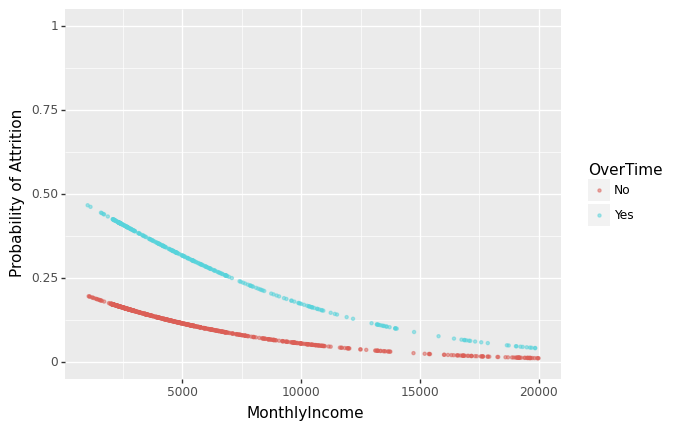

<ggplot: (17592027112617)>

In [24]:
pred = pd.DataFrame(
  lr_fit3.predict_proba(feat),
  columns=["No", "Yes"]
  )

pred = pred.join(X_train[["MonthlyIncome", "OverTime"]].reset_index(drop=True))

(ggplot(pred, aes("MonthlyIncome", "Yes", color="OverTime"))
  + geom_point(alpha=0.5, size=0.8)
  + scale_y_continuous(name="Probability of Attrition", limits=(0, 1)))

## Assessing model accuracy

### Basic model performance

In [25]:
lr1_pred = lr_fit1.predict_proba(X_train[["MonthlyIncome"]])
auc = roc_auc_score(y_train, lr1_pred[:, 1])
round(auc, 3)

0.658

### Cross-validation performance

In [26]:
cv_lr = LogisticRegressionCV(
  cv=5, 
  solver='liblinear',
  scoring='roc_auc',
  random_state=123).fit(X_train[["MonthlyIncome"]], y_train)

auc = cv_lr.score(X_train[["MonthlyIncome"]], y_train)
round(auc, 3)

0.658

### Model comparison performance

In [27]:
# feature sets to compare across
feature_set1 = X_train[["MonthlyIncome"]]
feature_set2 = pd.get_dummies(X_train[["OverTime"]].copy())
feature_set3 = feat = pd.get_dummies(X_train[["OverTime"]].copy())
feature_set3["MonthlyIncome"] = X_train["MonthlyIncome"]
feature_sets = {'lr1': feature_set1, 'lr2': feature_set2, 'lr3': feature_set3}

# object to store CV RMSE results
results = {}

for name, feat in feature_sets.items():
  # train LR model
  cv_lr = LogisticRegressionCV(
    cv=5, 
    solver='liblinear',
    scoring='roc_auc',
    random_state=123).fit(feat, y_train)

  auc = cv_lr.score(feat, y_train)
  results[name] = round(auc, 3)
  
# print out results
results

{'lr1': 0.658, 'lr2': 0.638, 'lr3': 0.723}

### Performance visualization

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


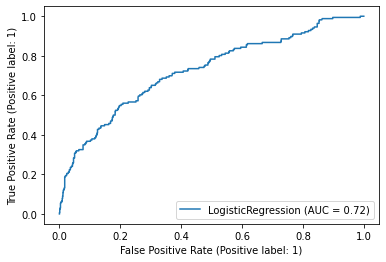

In [28]:
# the built in ROC curve plot uses matplotlib
import matplotlib.pyplot as plt

# create OverTime & MonthlyIncome features
feat = pd.get_dummies(X_train[["OverTime"]].copy())
feat["MonthlyIncome"] = X_train["MonthlyIncome"]

# model 3
lr_mod = LogisticRegression()
lr_fit3 = lr_mod.fit(feat, y_train)

# create ROC curve
plot_roc_curve(lr_fit3, feat, y_train)  
plt.show()

## Exercises

Using the spam data set from the kernlab package:

1. Pick a single feature and apply simple logistic regression model.
   - Interpret the feature's coefficient
   - What is the model's performance?
2. Pick another feature to add to the model.
   - Before applying the module why do you think this feature will help?
   - Apply a logistic regression model with the two features and compare to the simple linear model.
   - Interpret the coefficients.
3. Now apply a model that includes all the predictors.
   - How does this model compare to the previous two?
4. Plot an ROC curve comparing the performance of all three models
5. Compute and interpret the following performance metrics:
   - No information rate
   - accuracy rate
   - sensitivity
   - specificity